# LAB 597: Make More Informed Decisions with Geospatial Intelligence

Welcome! In this lab you will take your first steps with geospatial data and see how satellite imagery can answer a real community question: *How hot are school campuses, and how might greening help?* You do **not** need prior GIS or remote sensing experience—each concept is introduced briefly and applied immediately.



## What Is Geospatial Data?

Geospatial data is any information tied to a location on Earth. Instead of just rows and columns, we also have shapes (points, lines, polygons) or pixels that map to latitude/longitude. Examples:

- A point: the centroid of a school

- A polygon: the outline (footprint) of a campus

- A raster (grid): a satellite image where each pixel stores a value (like temperature or vegetation)



By combining these, we can ask location-based questions: Which schools have the least vegetation? Which campuses run hottest in summer? Where should we prioritize cooling investments?



## Microsoft Planetary Computer (MPC)

The Microsoft Planetary Computer hosts curated, analysis-ready environmental datasets (imagery, climate layers, elevation, land cover, and more) and provides APIs + scalable infrastructure so you can:

1. Discover trusted geospatial datasets via STAC (a common catalog standard)

2. Access them efficiently as Cloud-Optimized GeoTIFFs (stream only the pixels you need)

3. Combine multiple data sources to solve real-world sustainability and resilience problems



In this lab we will use MPC to pull:

- **NAIP aerial imagery** for a clear visual + vegetation (NDVI) indicator

- **Landsat thermal data** for land surface temperature (LST)



## The Basic Analysis Workflow

This lab mirrors a repeatable pattern used in geospatial analytics at larger scales:

1. **Identify facilities (areas) of interest** – We load all school footprints and select one pilot campus.

2. **Gather the required data** – Query MPC for imagery (NAIP) and temperature (Landsat) that intersect the campus.

3. **Run a model or calculation** – Compute vegetation (NDVI) and mean land surface temperature from clipped pixels, applying quality masks.

4. **Present findings** – Summarize and visualize: How does temperature vary across multiple summer observations? What might that imply for greening strategies?



> At enterprise or “planetary” scale the exact same pattern applies—you just automate it across thousands of sites and many time periods, then store aggregated metrics for decision-makers.



## What You Will Do Here

- Load and inspect a school footprint dataset

- Clip high‑resolution imagery and thermal pixels to a single campus

- Calculate NDVI (vegetation index) and mean land surface temperature

- Explore multiple summer observations to understand temporal variation



## Why It Matters

Urban heat and equitable access to cool, green spaces are public health issues. Geospatial intelligence transforms raw pixels into actionable metrics that help communities decide **where** to invest and **why**.



---

To start, let's install the required python packages into the computing environment. 

In [0]:
# Install session dependencies if needed (uncomment when running locally)
%pip install --quiet planetary-computer pystac-client stackstac rioxarray geopandas shapely rasterio folium tqdm contextily nbformat

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


Next, we will import those function into memory and make them available for future use.

In [0]:
# %run "./gecatalog-functions.ipynb"

import os
from typing import Tuple, Callable, TypeVar, Union

import azure.core.credentials
import azure.identity
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import httpx
import planetary_computer as pc
import pystac
import rasterio
import rioxarray
import xarray as xr
from pyproj import Transformer
from pystac_client import Client
from shapely.geometry import shape, mapping
from shapely.ops import transform
from rasterio.mask import mask
from zoneinfo import ZoneInfo
import datetime
from datetime import timezone
from typing import TypedDict

In [0]:


MPC_APP_ID = "https://geocatalog.spatio.azure.com"

RequestT = TypeVar("RequestT", bound=Union[requests.Request, httpx.Request])

def get_token(credential: azure.core.credentials.TokenCredential, app_id: str) -> str:
    return credential.get_token(f"{app_id}/.default").token

token = sc.broadcast(get_token(azure.identity.ManagedIdentityCredential(), MPC_APP_ID))

def token_auth(
    credential: azure.core.credentials.TokenCredential, app_id: str
) -> Callable[[RequestT], RequestT]:
    def _(request: RequestT) -> RequestT:
        request.headers["Authorization"] = f"Bearer {token.value}"
        return request

    return _
geocatalog_url = "https://emiliod-test-ncusa.fmhvgmdde4avckad.northcentralus.geocatalog.spatio.azure.com"
openpc = Client.open(
    f"{geocatalog_url}/stac",
    request_modifier=token_auth(azure.identity.ManagedIdentityCredential(), MPC_APP_ID))
# openpc = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1', modifier=pc.sign_inplace)

def get_collection_sas_token(collection_id: str) -> str:
    return requests.get(f"{geocatalog_url}/sas/token/{collection_id}", headers={'Authorization': f'Bearer {token.value}'}, params={"api-version": "2025-04-30-preview"}).json()['token']
naip_sas_token = get_collection_sas_token("naip")
landsat_sas_token = get_collection_sas_token("landsat-c2-l2")

In [0]:
class CampusResult(TypedDict):
    valid_pixels: int
    mean_temp_c: float
    mean_temp_f: float
    acquisition_date: datetime.datetime

# Helper functions for bounding boxes and STAC search
def expand_bounds(bounds: Tuple[float, float, float, float], buffer_degrees: float = 0.0008) -> Tuple[float, float, float, float]:
    xmin, ymin, xmax, ymax = bounds
    return (xmin - buffer_degrees, ymin - buffer_degrees, xmax + buffer_degrees, ymax + buffer_degrees)

def most_recent_openpc_item(collection: str, bbox: Tuple[float, float, float, float], start: str, end: str, **search_kwargs):
    """Return the most recent STAC item intersecting the bbox and date range."""
    search_parameters = {
        'collections': [collection],
        'bbox': bbox,
        'datetime': f"{start}/{end}",
        'max_items': search_kwargs.pop('max_items', 20),
        'limit': search_kwargs.pop('limit', 20),
        'sortby': search_kwargs.pop('sortby', [{'field': 'properties.datetime', 'direction': 'desc'}]),
    }
    search_parameters.update(search_kwargs)
    results = openpc.search(**search_parameters).item_collection()
    if not results:
        raise ValueError(f'No items found for collection={collection} in the requested window.')
    return results[0]

def display_school_footprint(school: gpd.GeoDataFrame):
    # Quick visualization of the pilot school footprint on a tiled basemap
    school_shape = school.geometry.iloc[0]
    school_centroid = school_shape.centroid
    pilot_gdf = gpd.GeoDataFrame({'name': [school.name]}, geometry=[school_shape], crs='EPSG:4326')
    pilot_gdf_3857 = pilot_gdf.to_crs(epsg=3857)
    pilot_centroid_3857 = pilot_gdf_3857.geometry.centroid.iloc[0]

    fig, ax = plt.subplots(figsize=(6, 6))
    pilot_gdf_3857.plot(ax=ax, facecolor='#2e8b57', edgecolor='#115533', alpha=0.35, linewidth=2)
    ax.scatter(pilot_centroid_3857.x, pilot_centroid_3857.y, color='darkgreen', s=40, label='Campus centroid')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_title(f"{school.name} campus footprint", fontsize=12)
    ax.legend(loc='upper right')
    ax.set_axis_off()
    caption = f"Centroid: {school_centroid.y:.4f}°N, {school_centroid.x:.4f}°E"
    # plt.suptitle('Only the campus polygon is rendered; background tiles provide familiar context.', fontsize=9, y=0.94)
    plt.figtext(0.5, 0.02, caption, ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()

def display_school_results(schools: gpd.GeoDataFrame):
    # Quick visualization of the pilot school footprint on a tiled basemap
    fig, ax = plt.subplots(figsize=(10, 10))
    for idx, row in schools.iterrows():
        school = gpd.GeoDataFrame([row], geometry='geometry', crs=schools_gdf.crs)
        school_shape = school.geometry.iloc[0]
        pilot_gdf = gpd.GeoDataFrame({'name': [school.name]}, geometry=[school_shape], crs='EPSG:4326')
        pilot_gdf_3857 = pilot_gdf.to_crs(epsg=3857)
        # Use NDVI colormap for mean_ndvi column
        mean_ndvi = row.get('mean_ndvi', np.nan)
        # Use RdYlGn colormap, vmin=-1, vmax=1, as in display_school_naip_ndvi
        cmap = plt.get_cmap('RdYlGn')
        color = cmap((mean_ndvi + 1) / 2) if np.isfinite(mean_ndvi) else (0.7, 0.7, 0.7, 0.35)
        pilot_gdf_3857.plot(ax=ax, facecolor=color, edgecolor='#115533', alpha=0.35, linewidth=2)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_title(f"ALl campus footprints", fontsize=12)
    ax.legend(loc='upper right')
    ax.set_axis_off()
    # plt.suptitle('Only the campus polygon is rendered; background tiles provide familiar context.', fontsize=9, y=0.94)
    # plt.figtext(0.5, 0.02, caption, ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()

# Use COG-friendly windowed read + mask so we download only pixels intersecting the campus
def open_clipped_naip(naip_item: pystac.Item, school: gpd.GeoDataFrame) -> xr.DataArray:
    naip_asset = naip_item.assets['image']
    naip_href_signed = f"{naip_asset.href}?{naip_sas_token}" # pc.sign(naip_asset.href)
    with rasterio.open(naip_href_signed) as src:
        reproj = Transformer.from_crs('EPSG:4326', src.crs, always_xy=True).transform
        school_shape = school.geometry.iloc[0]
        pilot_shape_src = transform(reproj, school_shape)
        clipped_data, clipped_transform = mask(src, [mapping(pilot_shape_src)], crop=True)
        clipped_data = clipped_data.astype('float32')
        if src.nodata is not None:
            clipped_data = np.where(clipped_data == src.nodata, np.nan, clipped_data)
        naip_clip = xr.DataArray(
            clipped_data,
            dims=("band", "y", "x"),
            coords={"band": list(src.indexes)},
            name="naip_rgb",
        ).rio.write_transform(clipped_transform).rio.write_crs(src.crs)
    return naip_clip

def display_school_naip_visual(naip_item: pystac.Item, school: gpd.GeoDataFrame):
    naip_clip = open_clipped_naip(naip_item, school)
    # Display a contrast-stretched RGB image so students can recognize the campus
    rgb = np.stack([naip_clip.sel(band=i).values for i in (1, 2, 3)], axis=-1)
    if np.isfinite(rgb).any():
        low, high = np.nanpercentile(rgb[np.isfinite(rgb)], (2, 98))
        scale = max(high - low, 1)
        rgb_normalized = np.clip((rgb - low) / scale, 0, 1)
    else:
        rgb_normalized = np.zeros_like(rgb, dtype="float32")

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(rgb_normalized)
    ax.set_title(f"{school.name} campus (NAIP true color)")
    ax.axis("off")
    plt.show()

def display_school_naip_ndvi(naip_item: pystac.Item, school: gpd.GeoDataFrame):
    naip_clip = open_clipped_naip(naip_item, school)
    # Compute NDVI from NAIP (band order: R, G, B, NIR)
    red = naip_clip.sel(band=1).astype('float32')
    nir = naip_clip.sel(band=4).astype('float32')
    ndvi = (nir - red) / (nir + red)
    ndvi = ndvi.where(np.isfinite(ndvi))
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    naip_rgb = np.stack([naip_clip.sel(band=i).values for i in (1, 2, 3)])
    naip_rgb_plot = np.transpose(naip_rgb, (1, 2, 0))
    axes[0].imshow(np.clip(naip_rgb_plot / np.nanmax(naip_rgb_plot), 0, 1))
    axes[0].set_title('NAIP RGB (preview)')
    axes[0].axis('off')
    ndvi_im = axes[1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[1].set_title('NDVI')
    axes[1].axis('off')
    fig.colorbar(ndvi_im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.show()
    print(f"Mean NDVI over campus: {ndvi.mean().item():.3f}")

def compute_mean_ndvi(naip_item: pystac.Item, school: gpd.GeoDataFrame) -> float:
    naip_clip = open_clipped_naip(naip_item, school)
    red = naip_clip.sel(band=1).astype('float32')
    nir = naip_clip.sel(band=4).astype('float32')
    ndvi = (nir - red) / (nir + red)
    ndvi = ndvi.where(np.isfinite(ndvi))
    return float(ndvi.mean().item())

def collect_analysis_items(
        school_bounds: Tuple[float, float, float, float],
        temporal_start: str = '2023-01-01',
        temporal_end : str | None = None,
) -> Tuple[pystac.Item, list[pystac.Item]]:
    if temporal_end is None:
        temporal_end = pd.Timestamp.utcnow().strftime("%Y-%m-%d")
    expanded_bounds = expand_bounds(school_bounds)
    naip_item = most_recent_openpc_item('naip', expanded_bounds, temporal_start, temporal_end)

    landsat_candidates : list[pystac.Item] = []
    landsat_asset_skip_log = []

    required_common_assets_primary = {"qa_pixel"}
    primary_lst_candidates_single = ("ST_B10", "ST_B11", "lwir")
    fallback_lst_requirements_single = {"trad", "urad", "drad", "emis", "atran", "mtl.json"}

    landsat_search = openpc.search(
        collections=['landsat-c2-l2'],
        bbox=expanded_bounds,
        datetime=f"{temporal_start}/{temporal_end}",
        query={'eo:cloud_cover': {'lt': 20}},
        limit=60,
        max_items=60,
        sortby=[{'field': 'properties.datetime', 'direction': 'desc'}],
        fields={'exclude': ['links', 'collection', 'assets.*.alternate']}
    )

    for candidate in landsat_search.items():
        asset_keys = set(candidate.assets.keys())
        if not required_common_assets_primary.issubset(asset_keys):
            landsat_asset_skip_log.append({
                'id': candidate.id,
                'datetime': candidate.datetime.isoformat(),
                'missing_assets': sorted(required_common_assets_primary - asset_keys)
            })
            continue
        if not any(name in asset_keys for name in primary_lst_candidates_single):
            missing_fallback = fallback_lst_requirements_single - asset_keys
            if missing_fallback:
                landsat_asset_skip_log.append({
                    'id': candidate.id,
                    'datetime': candidate.datetime.isoformat(),
                    'missing_assets': sorted(missing_fallback)
                })
                continue
        landsat_candidates.append(candidate)
        if len(landsat_candidates) >= 12:
            break

    if not landsat_candidates:
        if landsat_asset_skip_log:
            print("No Landsat items with required assets. Sample of missing asset diagnostics:")
            for entry in landsat_asset_skip_log[:10]:
                missing_list = ', '.join(entry['missing_assets']) or 'unknown'
                print(f"  - {entry['id']} ({entry['datetime']}): missing {missing_list}")
            if len(landsat_asset_skip_log) > 10:
                print(f"  ...and {len(landsat_asset_skip_log) - 10} more")
        raise ValueError("Unable to find Landsat candidates with the required thermal assets in the requested window.")

    return naip_item, landsat_candidates

def load_landsat_lst(item, school, clip_crs='EPSG:4326', enforce_limits=(-40.0, 70.0)) -> xr.DataArray:
    """Load Landsat Collection 2 L2 surface temperature, apply QA masking, and return LST in °C.

    The Microsoft Planetary Computer serves Landsat assets as Cloud-Optimized GeoTIFFs (COGs), so we
    read only the pixels that intersect the campus footprint using ``rasterio.mask`` instead of
    downloading full rasters. We preferentially use the calibrated ``ST_B10``/``ST_B11`` surface
    temperature bands. If they are missing, we fall back to the radiative transfer workflow.

    ``clip_geoms`` may contain GeoJSON dicts or shapely geometries expressed in ``clip_crs``.
    ``enforce_limits`` filters out unreasonable temperatures (defaults to -40°C..70°C).
    """

    school_shape = school.geometry.iloc[0]
    clip_geoms = [mapping(school_shape)]
    def _to_shapes(geoms):
        shapes_out = []
        for geom in geoms:
            if isinstance(geom, dict):
                shapes_out.append(shape(geom))
            elif hasattr(geom, "__geo_interface__"):
                shapes_out.append(shape(geom.__geo_interface__))
            else:
                shapes_out.append(geom)
        return shapes_out

    def _scale_and_offset(band_meta):
        scale = band_meta.get('scale')
        if scale is None:
            scales = band_meta.get('scales')
            if isinstance(scales, (list, tuple)) and scales:
                scale = scales[0]
        if scale is None:
            scale = 1.0
        offset = band_meta.get('offset')
        if offset is None:
            offsets = band_meta.get('offsets')
            if isinstance(offsets, (list, tuple)) and offsets:
                offset = offsets[0]
        if offset is None:
            offset = 0.0
        return float(scale), float(offset)

    def _read_asset(asset, dtype='float32', fill_value=np.nan):
        href = f"{asset.href}?{landsat_sas_token}" # pc.sign(asset.href)
        clip_shapes = _to_shapes(clip_geoms)
        with rasterio.open(href) as src:
            src_crs = src.crs
            if clip_crs and src_crs and clip_crs != src_crs.to_string():
                transformer = Transformer.from_crs(clip_crs, src_crs, always_xy=True)
                shapes_native = [transform(transformer.transform, geom) for geom in clip_shapes]
            else:
                shapes_native = clip_shapes
            shapes_geojson = [mapping(geom) for geom in shapes_native]
            data, out_transform = mask(src, shapes_geojson, crop=True, filled=False)
            mask_arr = np.ma.getmaskarray(data)
            data = data.astype(dtype)
            if data.shape[0] == 1:
                band_data = data[0]
                band_mask = mask_arr[0]
            else:
                band_data = data[0]
                band_mask = mask_arr[0]
            band_data = np.where(band_mask, fill_value, band_data)
            da = xr.DataArray(band_data, dims=("y", "x"))
            da = da.rio.write_transform(out_transform).rio.write_crs(src_crs)
            return da

    clip_shapes = _to_shapes(clip_geoms)
    if not clip_shapes:
        raise ValueError("clip_geoms must contain at least one geometry")

    qa_asset = item.assets.get('qa_pixel')
    if qa_asset is None:
        raise KeyError('qa_pixel asset is required for masking.')
    qa = _read_asset(qa_asset, dtype='uint32', fill_value=0)
    cloud_mask = (
        ((qa & (1 << 1)) != 0)
        | ((qa & (1 << 2)) != 0)
        | ((qa & (1 << 3)) != 0)
        | (((qa >> 4) & 0b11) >= 2)
        | (((qa >> 6) & 0b11) >= 2)
    )

    lst_asset = item.assets.get('ST_B10') or item.assets.get('ST_B11') or item.assets.get('lwir')
    lst_kelvin = None
    if lst_asset is not None:
        lst_da = _read_asset(lst_asset, dtype='float32', fill_value=np.nan)
        band_meta = lst_asset.extra_fields.get('raster:bands', [{}])[0]
        scale, offset = _scale_and_offset(band_meta)
        lst_kelvin = lst_da * scale + offset
        lst_kelvin = xr.where(cloud_mask, np.nan, lst_kelvin)

    if lst_kelvin is None:
        thermal_radiance_keys = ['trad', 'urad', 'drad', 'emis', 'atran']
        missing_keys = [key for key in thermal_radiance_keys if key not in item.assets]
        if missing_keys:
            raise KeyError(f"Unable to locate LST assets: {', '.join(missing_keys)}")

        clipped_assets = {}
        for key in thermal_radiance_keys:
            asset = item.assets[key]
            band_meta = asset.extra_fields.get('raster:bands', [{}])[0]
            scale, offset = _scale_and_offset(band_meta)
            da = _read_asset(asset, dtype='float32', fill_value=np.nan)
            clipped_assets[key] = da * scale + offset

        rad = clipped_assets['trad']
        up = clipped_assets['urad']
        down = clipped_assets['drad']
        emissivity = clipped_assets['emis'].clip(0.0001, 0.9999)
        transmittance = clipped_assets['atran'].clip(0.0001)

        radiance_surface = (rad - up - (1 - emissivity) * down) / (emissivity * transmittance)
        radiance_surface = xr.where((radiance_surface <= 0) | cloud_mask, np.nan, radiance_surface)
        # Determine thermal conversion constants
        mtl_href = f"{item.assets['mtl.json'].href}?{landsat_sas_token}"# pc.sign(item.assets['mtl.json'].href)
        mtl_response = requests.get(mtl_href, timeout=30)
        mtl_response.raise_for_status()
        metadata = mtl_response.json()['LANDSAT_METADATA_FILE']
        thermal_constants = metadata.get('LEVEL1_THERMAL_CONSTANTS', {})
        band_priority = [
            ('K1_CONSTANT_BAND_10', 'K2_CONSTANT_BAND_10'),
            ('K1_CONSTANT_BAND_11', 'K2_CONSTANT_BAND_11'),
            ('K1_CONSTANT_BAND_6_VCID_1', 'K2_CONSTANT_BAND_6_VCID_1'),
            ('K1_CONSTANT_BAND_6_VCID_2', 'K2_CONSTANT_BAND_6_VCID_2'),
        ]
        k1 = k2 = None
        for k1_key, k2_key in band_priority:
            if k1_key in thermal_constants and k2_key in thermal_constants:
                k1 = float(thermal_constants[k1_key])
                k2 = float(thermal_constants[k2_key])
                break
        if k1 is None or k2 is None:
            raise KeyError('Unable to determine thermal conversion parameters for this item')
        lst_kelvin = k2 / np.log((k1 / radiance_surface) + 1)

    lst_celsius = lst_kelvin - 273.15
    lst_celsius = lst_celsius.where(np.isfinite(lst_celsius))
    if enforce_limits is not None:
        min_c, max_c = enforce_limits
        lst_celsius = lst_celsius.where((lst_celsius >= min_c) & (lst_celsius <= max_c))
    return lst_celsius

def landsat_item_has_required_assets(item: pystac.Item) -> Tuple[bool, dict | None]:
    required_common_assets = {"qa_pixel"}
    primary_lst_candidates = ("ST_B10", "ST_B11", "lwir")
    fallback_lst_requirements = {"trad", "urad", "drad", "emis", "atran", "mtl.json"}
    asset_keys = set(item.assets.keys())
    if not required_common_assets.issubset(asset_keys):
        return False, {"missing": sorted(required_common_assets - asset_keys)}
    if any(candidate in asset_keys for candidate in primary_lst_candidates):
        return True, None
    missing_fallback = fallback_lst_requirements - asset_keys
    if missing_fallback:
        return False, {"missing": sorted(missing_fallback)}
    return True, None

def campus_lst_summary(landsat_item: pystac.Item, school: gpd.GeoDataFrame) -> None | CampusResult:
    first_lst = load_landsat_lst(landsat_item, school)
    # items, prefetched_lst_by_id= search_landsat_summers(school)
    valid_pixels = int(np.isfinite(first_lst).sum().item())
    mean_temp_c = float(first_lst.mean().item()) if valid_pixels else float('nan')
    mean_temp_f = (mean_temp_c * 9 / 5 + 32) if valid_pixels else float('nan')

    acquisition_dt = landsat_item.datetime
    assert acquisition_dt is not None
    acquisition_local = None
    acquisition_dt = acquisition_dt.replace(tzinfo=timezone.utc)
    acquisition_local = acquisition_dt.astimezone(ZoneInfo('America/Phoenix'))
    return {
        "valid_pixels": valid_pixels,
        "mean_temp_c": mean_temp_c,
        "mean_temp_f": mean_temp_f,
        # lst_min
        # lst_max
        # lst_median
        # ndvi_mean
        "acquisition_date": acquisition_local,
    }

def search_landsat_summers(
        school: gpd.GeoDataFrame,
        start_year: int = 2015,
        end_year: int = 2025,
        desired_samples: int = 15,
) -> Tuple[list[pystac.Item], dict[str, xr.DataArray]]:
    # Search for cloud-free Landsat summer observations across multiple years

    school_bounds = school.bounds.iloc[0]
    safety_multiplier = 6
    search_limit = max(desired_samples * safety_multiplier, 60)

    summer_items = []
    prefetched_lst_by_id = {}
    asset_skip_log = []
    data_skip_log = []

    search_start = f"{start_year}-06-01"
    search_end = f"{end_year}-08-31"

    search = openpc.search(
        collections=['landsat-c2-l2'],
        bbox=expand_bounds(school_bounds),
        datetime=f"{search_start}/{search_end}",
        query={
            'landsat:cloud_cover_land': {'eq': 0},
            'eo:cloud_cover': {'eq': 0},
        },
        limit=search_limit,
        max_items=search_limit,
        sortby=[{'field': 'properties.datetime', 'direction': 'desc'}],
        fields={'exclude': ['links', 'collection', 'assets.*.alternate']}
    )

    for item in search.items():
        if item.datetime.month not in (6, 7, 8):
            continue
        has_assets, details = landsat_item_has_required_assets(item)
        if not has_assets:
            asset_skip_log.append({
                'id': item.id,
                'datetime': item.datetime.isoformat(),
                'missing_assets': details.get('missing', [])
            })
            continue
        try:
            lst_candidate = load_landsat_lst(item, school)
        except KeyError as exc:
            data_skip_log.append({
                'id': item.id,
                'datetime': item.datetime.isoformat(),
                'reason': f'Missing expected asset while loading LST: {exc}'
            })
            continue
        except requests.exceptions.RequestException as exc:
            data_skip_log.append({
                'id': item.id,
                'datetime': item.datetime.isoformat(),
                'reason': f'HTTP error while loading LST assets: {exc}'
            })
            continue
        except rasterio.errors.RasterioError as exc:
            data_skip_log.append({
                'id': item.id,
                'datetime': item.datetime.isoformat(),
                'reason': f'Raster read error while loading LST: {exc}'
            })
            continue
        if lst_candidate is None or np.isnan(lst_candidate).all():
            data_skip_log.append({
                'id': item.id,
                'datetime': item.datetime.isoformat(),
                'reason': 'All pixels masked or empty during prefetch validation'
            })
            continue
        valid_pixels = int(np.isfinite(lst_candidate).sum().item())
        if valid_pixels == 0:
            data_skip_log.append({
                'id': item.id,
                'datetime': item.datetime.isoformat(),
                'reason': 'No valid pixels after QA during prefetch validation'
            })
            continue
        prefetched_lst_by_id[item.id] = lst_candidate
        summer_items.append(item)
        if len(summer_items) >= desired_samples:
            break

    if len(summer_items) < desired_samples:
        if asset_skip_log:
            print("Scenes skipped due to missing asset keys:")
            for entry in asset_skip_log[:10]:
                missing_list = ', '.join(entry['missing_assets']) or 'unknown'
                print(f"  - {entry['id']} ({entry['datetime']}): missing {missing_list}")
            if len(asset_skip_log) > 10:
                print(f"  ...and {len(asset_skip_log) - 10} more")
        if data_skip_log:
            print("Scenes skipped after attempting to load LST during validation:")
            for entry in data_skip_log[:10]:
                print(f"  - {entry['id']} ({entry['datetime']}): {entry['reason']}")
            if len(data_skip_log) > 10:
                print(f"  ...and {len(data_skip_log) - 10} more")
        raise ValueError(
            f"Only found {len(summer_items)} asset-complete, data-validated cloud-free summer scenes after filtering; consider relaxing filters or extending the date range."
        )
    if asset_skip_log:
        print(f"Skipped {len(asset_skip_log)} scenes lacking required assets before validation.")
    if data_skip_log:
        print(f"Skipped {len(data_skip_log)} scenes during data validation.")
    print(
        f"Total asset-complete, data-validated summer candidates collected (searching {end_year}→{start_year} summers): {len(summer_items)}"
    )
    return summer_items, prefetched_lst_by_id

def collect_summertime_lst(school: gpd.GeoDataFrame) -> pd.DataFrame:
    summer_items, prefetched_lst_by_id = search_landsat_summers(school)
    # return summer_items, prefetched_lst_by_id

    records = []
    skipped = []

    for item in summer_items:
        lst = prefetched_lst_by_id.get(item.id)
        if lst is None:
            try:
                lst = load_landsat_lst(item, school)
            except KeyError as exc:
                skipped.append({'landsat_id': item.id, 'reason': f'Missing expected asset while loading LST: {exc}'})
                continue
            except requests.exceptions.RequestException as exc:
                skipped.append({'landsat_id': item.id, 'reason': f'HTTP error: {exc}'})
                continue
            except rasterio.errors.RasterioError as exc:
                skipped.append({'landsat_id': item.id, 'reason': f'Raster read error: {exc}'})
                continue
        if lst is None or np.isnan(lst).all():
            skipped.append({'landsat_id': item.id, 'reason': 'All pixels masked or empty'})
            continue
        valid_pixels = int(np.isfinite(lst).sum().item())
        if valid_pixels == 0:
            skipped.append({'landsat_id': item.id, 'reason': 'No valid pixels after QA'})
            continue
        mean_temp = float(lst.mean().item())
        median_temp = float(lst.median().item())
        min_temp = float(lst.min().item())
        max_temp = float(lst.max().item())
        records.append({
            'datetime': item.datetime,
            'landsat_id': item.id,
            'mean_temp_c': mean_temp,
            'median_temp_c': median_temp,
            'min_temp_c': min_temp,
            'max_temp_c': max_temp,
            'valid_pixels': valid_pixels,
        })

    if not records:
        raise ValueError("No usable LST scenes were found; consider relaxing filters or expanding the search window.")

    return pd.DataFrame(records).sort_values('datetime').reset_index(drop=True)

For this lab, we have used the [Open Street Map](https://www.openstreetmap.org/#map=5/38.01/-95.84) project to generate a list of schools in the Phoenix area. These schools were put into a [GeoJSON format](https://en.wikipedia.org/wiki/GeoJSON) and saved as a file we will use.  

In [0]:
# os.environ.setdefault("OGR_GEOMETRY_ACCEPT_UNCLOSED_RING", "YES")\
schools_raw = gpd.read_file("/Workspace/Shared/phoenix_schools.geojson", engine="pyogrio", on_invalid="fix")
schools_gdf = schools_raw.dropna(subset=["name"])[schools_raw.geometry.type == "Polygon"].to_crs("EPSG:4326")
# schools_raw = gpd.read_file("phoenix_schools.geojson", engine='pyogrio', on_invalid='fix')
# schools_gdf = schools_raw.to_crs('EPSG:4326')
print(f"Total school features: {len(schools_gdf):,}")
schools_gdf[['name', 'amenity']].head()

Total school features: 374


/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: Non closed ring detected.
  return ogr_read(


,name,amenity
2,Biltmore Preparatory Academy,school
3,Roosevelt School,school
4,Madison School Number Two,school
5,Kenilworth School,school
6,Nevitt School,school


Now that we have a list of the schools in Phoenix, we are going to randomly select one to test the workflow. This code takes the selected school and prints out its properties.

In [0]:
rng = np.random.RandomState(2)  # make a deterministic generator
school = schools_gdf.sample(1, random_state=rng)
school_shape = school.geometry.iloc[0]
school_bounds = school.bounds.iloc[0]
school_centroid = school_shape.centroid
print(f"Selected school: {school.name.iloc[0]}")
print(f"Location: {school_centroid.y:.5f}, {school_centroid.x:.5f}")

Selected school: Augustus H Shaw Junior School
Location: 33.44930, -112.05343


Given the boundaries of this school, lets take a look at it on a map. 

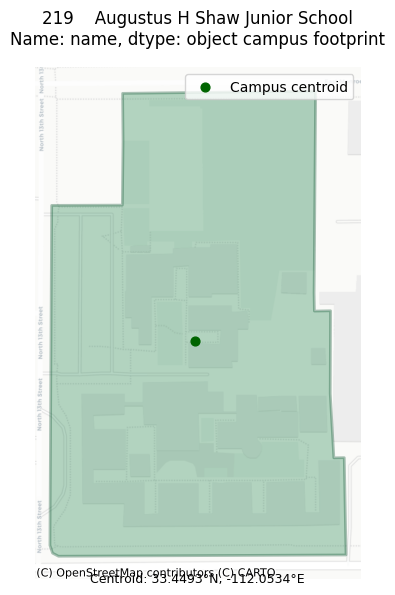

In [0]:
display_school_footprint(school)

Microsoft's Planetary Computer [Open Data Catalog](https://planetarycomputer.microsoft.com/catalog) contains 100's of datasets about the earth all organized in a common catalog format called the Spatio Temporal Asset Catalog, or [STAC](https://stacspec.org/en/). 

This is where we will find the [Landsat](https://www.usgs.gov/faqs/what-landsat-satellite-program-and-why-it-important) data to measure the temperature of the various schools. 



However, to actually look at the buildings and landscaping of these schools, we will need high-resolution aerial imagery.
Planetary Computer hosts the [NAIP](https://planetarycomputer.microsoft.com/dataset/naip) dataset, an annual high-resolution visual dataset of the United States.


In both cases, we need to _search_ for relevant data.
Planetary Computer's STAC API allows us to search for STAC items by matching temporal, spatial, and/or arbitrary property filters.

In [0]:
# Locate NAIP and Landsat scenes covering the campus
naip_item, landsat_candidates = collect_analysis_items(school_bounds)
landsat_item = landsat_candidates[0]  # placeholder until data validation
print(f"NAIP item: {naip_item.id}")
print(f"Initial Landsat candidate pool size: {len(landsat_candidates)} (newest first)")
print(f"First candidate to validate: {landsat_item.id}")

NAIP item: az_m_3311240_ne_12_030_20230917_20240304
Initial Landsat candidate pool size: 12 (newest first)
First candidate to validate: LC09_L2SP_037037_20251001_02_T1


### See the campus from above
Here's the true-color NAIP scene so students can orient themselves with a familiar aerial view before diving into the analytics.

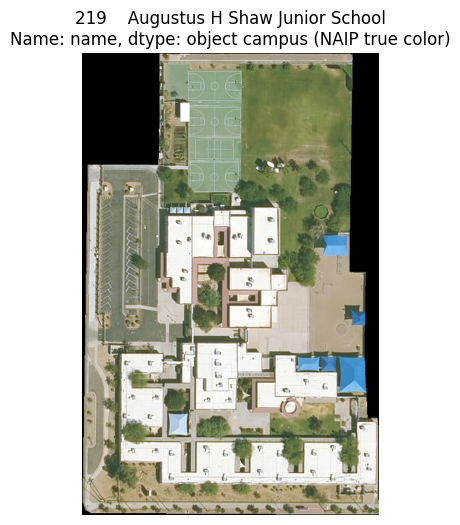

In [0]:
display_school_naip_visual(naip_item, school)

## NDVI 
The [normalized difference vegetation index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) measures the presence and health of vegetation.

The NAIP STAC item contain NDVI raster assets.
We can use that band to estimate the fraction of the land area of the school that contains vegetation.
Placing the visual and NDVI bands side-by-side, you can see that grassy and tree-lined areas are identified with NDVI values greater than 0.

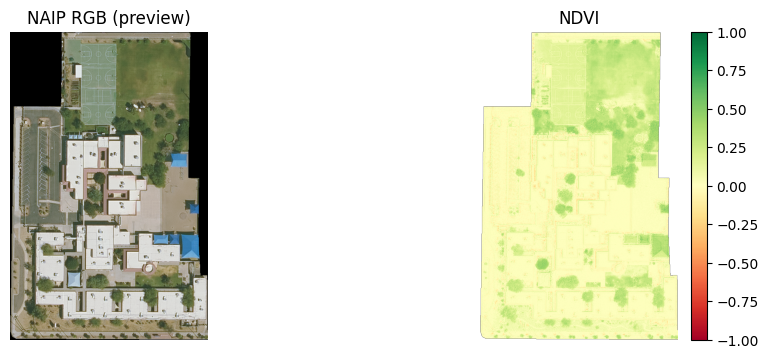

Mean NDVI over campus: 0.082


In [0]:
display_school_naip_ndvi(naip_item, school)

In [0]:
# Clip the first Landsat candidate to the campus and summarize mean surface temperature
campus_result = campus_lst_summary(landsat_item, school)
assert campus_result is not None
local_time_str = campus_result["acquisition_date"].strftime('%I:%M %p %Z')
print(f"First validated Landsat scene: {landsat_item.id}")
print(f"Valid pixels within campus mask: {campus_result["valid_pixels"]:,}")
if campus_result["valid_pixels"] > 0:
    date_str = campus_result["acquisition_date"].isoformat()
    print(f"Mean campus land surface temperature on {date_str} at {local_time_str}: {campus_result['mean_temp_c']:.2f} °C / {campus_result['mean_temp_f']:.2f} °F")
else:
    print("No valid LST pixels after QA masking; check asset availability or cloud filters.")

First validated Landsat scene: LC09_L2SP_037037_20251001_02_T1
Valid pixels within campus mask: 32
Mean campus land surface temperature on 2025-10-01T11:04:16.289060-07:00 at 11:04 AM MST: 43.52 °C / 110.34 °F


### Explore multi-summer land surface temperature (LST)
To understand seasonal variability, gather multiple cloud-free Landsat observations across several summers (June–August) and compare their campus-level land surface temperatures.

In [0]:
summer_items, prefetched_lst_by_id = search_landsat_summers(school)

Skipped 4 scenes during data validation.
Total asset-complete, data-validated summer candidates collected (searching 2025→2015 summers): 15


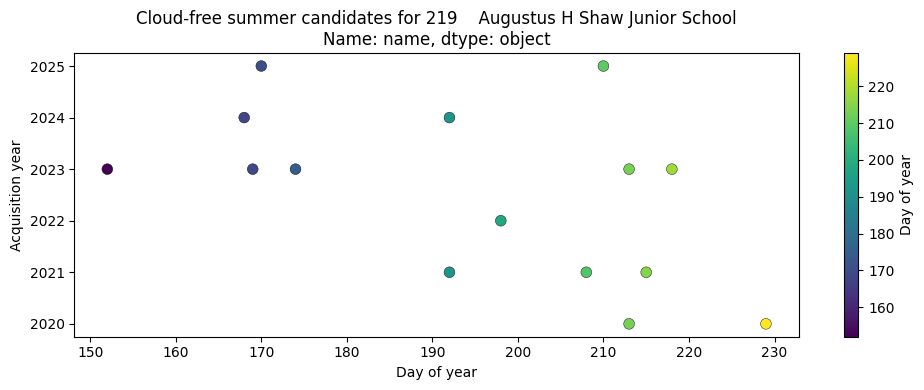

In [0]:
# Visualize the distribution of candidate scene dates
import calendar

summer_candidates_df = pd.DataFrame([
    {
        'datetime': item.datetime,
        'year': item.datetime.year,
        'month': calendar.month_abbr[item.datetime.month],
        'day_of_year': item.datetime.timetuple().tm_yday,
        'landsat_id': item.id,
        'satellite': item.properties.get('landsat:platform', 'unknown').upper(),
    }
    for item in summer_items
])

summer_candidates_df = summer_candidates_df.sort_values('datetime').reset_index(drop=True)
range_start = summer_candidates_df['datetime'].min()
range_end = summer_candidates_df['datetime'].max()
summer_candidates_df['days_since_start'] = (summer_candidates_df['datetime'] - range_start).dt.days
total_span_days = int((range_end - range_start).days)

fig, ax = plt.subplots(figsize=(10, 4))
scatter = ax.scatter(
    summer_candidates_df['day_of_year'],
    summer_candidates_df['year'],
    c=summer_candidates_df['day_of_year'],
    cmap='viridis',
    s=60,
    edgecolor='k',
    linewidth=0.3
 )
ax.set_title(f"Cloud-free summer candidates for {school.name}")
ax.set_xlabel('Day of year')
ax.set_ylabel('Acquisition year')
plt.colorbar(scatter, ax=ax, label='Day of year')
plt.tight_layout()
plt.show()

In [0]:
summer_landsat_df = collect_summertime_lst(school)
overall_mean_c = summer_landsat_df['mean_temp_c'].mean()
print(f"Collected {len(summer_landsat_df)} cloud-free summer observations")
print(f"Overall mean LST (°C): {overall_mean_c:.2f}")

display_columns = ['datetime', 'landsat_id', 'mean_temp_c', 'median_temp_c', 'min_temp_c', 'max_temp_c', 'valid_pixels']
summer_landsat_df[display_columns].head()

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-8071703601220920>, line 1
----> 1 summer_landsat_df = collect_summertime_lst(school)
      2 overall_mean_c = summer_landsat_df['mean_temp_c'].mean()
      3 print(f"Collected {len(summer_landsat_df)} cloud-free summer observations")

File <command-8071703601220901>, line 494, in collect_summertime_lst(school)
    493 def collect_summertime_lst(school: gpd.GeoDataFrame) -> pd.DataFrame:
--> 494     summer_items, prefetched_lst_by_id = search_landsat_summers(school)
    495     # return summer_items, prefetched_lst_by_id
    497     records = []

File <command-8071703601220901>, line 481, in search_landsat_summers(school, start_year, end_year, desired_samples)
    479         if len(data_skip_log) > 10:
    480             print(f"  ...and {len(data_skip_log) - 10} more")
--> 481     raise ValueError(
    482         f"Only

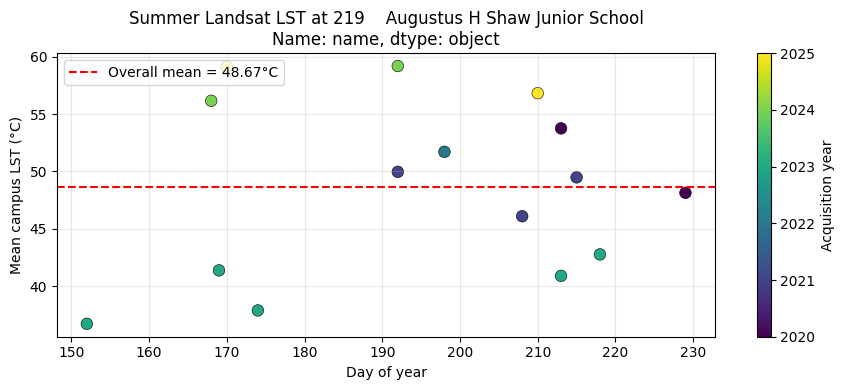

In [0]:
# Plot the temperature time series to show day-to-day variability
plot_df = summer_landsat_df.copy()
plot_df['day_of_year'] = plot_df['datetime'].dt.dayofyear
plot_df['year'] = plot_df['datetime'].dt.year

fig, ax = plt.subplots(figsize=(9, 4))
scatter = ax.scatter(
    plot_df['day_of_year'],
    plot_df['mean_temp_c'],
    c=plot_df['year'],
    cmap='viridis',
    s=70,
    edgecolor='k',
    linewidth=0.4,
    label=None
)
ax.axhline(overall_mean_c, color='red', linestyle='--', label=f'Overall mean = {overall_mean_c:.2f}°C')
ax.set_title(f"Summer Landsat LST at {school.name}")
ax.set_ylabel('Mean campus LST (°C)')
ax.set_xlabel('Day of year')
ax.grid(alpha=0.3)
legend_handles, legend_labels = ax.get_legend_handles_labels()
if legend_handles:
    ax.legend(loc='upper left')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Acquisition year')
plt.tight_layout()
plt.show()

Now we can repeat the analysis of mean landsurface temperature using many years of data to smooth out seasonal differences.

In [0]:
# for idx, row in schools_gdf.iterrows():
#     display(row)
#     break
records = schools_gdf.to_dict("records")
records[0:3]

[{'id': 'relation/18153619',
  '@id': 'relation/18153619',
  'addr:city': 'Phoenix',
  'addr:country': None,
  'addr:flats': None,
  'addr:full': None,
  'addr:housename': None,
  'addr:housenumber': '4601',
  'addr:postcode': '85018',
  'addr:state': 'AZ',
  'addr:street': 'North 34th Street',
  'addr:unit': None,
  'alt_name': None,
  'amenity': 'school',
  'barrier': None,
  'brand': None,
  'brand:wikidata': None,
  'building': None,
  'building:levels': None,
  'check_date': NaT,
  'construction': None,
  'contact:email': None,
  'contact:facebook': None,
  'contact:fax': None,
  'contact:phone': None,
  'contact:phone:enrollment': None,
  'contact:website': None,
  'denomination': None,
  'description': None,
  'designation': None,
  'ele': None,
  'elevation': '368',
  'email': None,
  'facebook': 'https://www.facebook.com/BiltmorePrepTigers/',
  'fax': None,
  'fixme': None,
  'generator:method': None,
  'generator:output:electricity': None,
  'generator:source': None,
  'gener

In [0]:
# results = []
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, FloatType

schema = StructType([
    StructField("name", StringType(), True),
    StructField("mean_temp_c", FloatType(), True),
    StructField("mean_ndvi", FloatType(), True)
])
gdf_serializable = schools_gdf.copy()
gdf_serializable["geometry"] = schools_gdf["geometry"].to_wkt()
rows = gdf_serializable.to_dict("records")
rdd = sc.parallelize(rows[0:10])

def process(row: dict):
    import geopandas as gpd
    from shapely import wkt
    import rioxarray
 
    school = gpd.GeoDataFrame([row])
    school["geometry"] = school["geometry"].apply(wkt.loads)
    school = school.set_geometry("geometry", crs="EPSG:4326")
    # school.crs = "EPSG:4326"
    print(f"Analyzing school: {school.name.iloc[0]}")
    naip_item, landsat_items = collect_analysis_items(school.bounds.iloc[0])
    summertime_lst = collect_summertime_lst(school)
    mean_temp_c = summertime_lst['mean_temp_c'].mean()
    mean_ndvi = compute_mean_ndvi(naip_item, school)
    return {
        'name': school.name.iloc[0],
        'mean_temp_c': float(mean_temp_c),
        'mean_ndvi': float(mean_ndvi)
    }
 
rdd_processed = rdd.map(process).map(lambda x: Row(**x)).toDF(schema=schema)
display(rdd_processed)
#token.close()

/root/.ipykernel/1664/command-8071703601220923-1041828587:11: UserWarning: Geometry column does not contain geometry.
  gdf_serializable["geometry"] = schools_gdf["geometry"].to_wkt()


name,mean_temp_c,mean_ndvi
Biltmore Preparatory Academy,48.324177,0.11327474
Roosevelt School,51.867737,0.037823822
Madison School Number Two,48.393692,0.09028106
Kenilworth School,51.324448,0.0838772
Nevitt School,50.081352,0.09220451
Garfield School,48.7561,0.08878336
Hidden Hills Elementary School,47.92181,0.08790238
Cholla Complex A.K.A. Gold Dust Elementary,48.09913,0.06497838
Horizon High School,49.041862,0.055138726
Larkspur Elementary School,49.703777,0.08822561


In [0]:
display(result_df)

In [0]:
# TODO add regression and correlation coefficients, and change color of top and least 5
schools_gdf[schools_gdf.mean_ndvi.notna()]
plt.figure(figsize=(7, 5))
plt.scatter(
    schools_gdf.mean_ndvi,
    schools_gdf.mean_temp_c,
    alpha=0.7,
    edgecolor='k'
)
plt.xlabel("Mean NDVI")
plt.ylabel("Mean Land Surface Temperature (°C)")
plt.title("School NDVI vs. Mean Summer Land Surface Temperature")
# TODO bring up the annual mean analysis instead of the point-in-time of landsat lst
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [0]:
display_school_results(schools_gdf[schools_gdf.mean_ndvi.notna()])

Visualize the top-5 hottest schools:

In [0]:
top5_schools = schools_gdf[schools_gdf['mean_temp_c'].notna()].sort_values('mean_temp_c', ascending=False).head(5)
display_columns = ['name', 'mean_temp_c', 'mean_ndvi']
print(top5_schools[display_columns])
for idx, row in top5_schools.iterrows():
    school = gpd.GeoDataFrame([row], geometry='geometry', crs=schools_gdf.crs)
    naip, _ = collect_analysis_items(school_bounds=school.bounds.iloc[0])
    display_school_naip_ndvi(naip, school)

And now the top 5 coolest schools:

In [0]:
top5_schools = schools_gdf[schools_gdf['mean_temp_c'].notna()].sort_values('mean_temp_c').head(5)
display_columns = ['name', 'mean_temp_c', 'mean_ndvi']
print(top5_schools[display_columns])
for idx, row in top5_schools.iterrows():
    school = gpd.GeoDataFrame([row], geometry='geometry', crs=schools_gdf.crs)
    naip, _ = collect_analysis_items(school_bounds=school.bounds.iloc[0])
    display_school_naip_ndvi(naip, school)

## Next steps
- Validate the NAIP + Landsat selections across different years to build a time series.
- Compare campus-level NDVI and LST against city-wide percentiles to rank schools.
- Persist clipped rasters or summary stats so the workshop can scale to dozens of campuses without re-querying raw imagery.